In [1]:
# Can set to 1 while iterating on the notebook
# Can set high (to 99) in final use, since we're using early stopping
EPOCHS = 99

BATCH_SIZE = 60

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
# Move all the files from the downloaded locations into format that 
# image_dataset_from_directory expects (one folder per label)

df=pd.read_csv('GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [4]:
# From above, we can see these labels
label_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']



label_names = sorted(label_names)
print(label_names)

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [5]:
# Add .jpg extension to the image filenames
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [6]:
# Define root directory
data_dir = '/home/padyal.s/emptydir'

### Introducing Thread Pool Executor for faster copying of large image data.

In [7]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

# Define root directory
data_dir = '/home/padyal.s/emptydir'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)

# Assume label_names is defined and contains the names of the directories to be created

def create_directory(dir_path):
    """
    Creates a directory at the specified path.
    """
    os.makedirs(dir_path)

# Parallel directory creation
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your environment
    # Prepare directory paths
    dir_paths = [os.path.join(data_dir, label) for label in label_names]
    # Execute directory creation tasks in parallel
    executor.map(create_directory, dir_paths)


In [8]:
from shutil import copyfile
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Assuming `df` is your DataFrame and `data_dir` is defined

def copy_image_to_label_dir(args):
    """
    Copies an image from the source to the target directory.
    """
    src_path, dst_path = args
    copyfile(src_path, dst_path)

def prepare_copy_tasks(row):
    """
    Prepares the source and destination paths for a given DataFrame row.
    """
    image_name = row['image']
    hot_label = row[row == 1].index.tolist()[0]
    src_path = os.path.join("Images", image_name)
    dst_path = os.path.join(data_dir, hot_label, image_name)
    return (src_path, dst_path)

# Use ThreadPoolExecutor to parallelize the copying process
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your environment
    # Prepare tasks
    tasks = df.apply(prepare_copy_tasks, axis=1)
    # Execute tasks in parallel and track progress with tqdm
    list(tqdm(executor.map(copy_image_to_label_dir, tasks), total=len(tasks), desc='Copying images..'))


Copying images..: 100%|██████████| 10015/10015 [00:35<00:00, 285.93it/s]


In [9]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 327 images with label AKIEC.
There are 514 images with label BCC.
There are 1099 images with label BKL.
There are 115 images with label DF.
There are 1113 images with label MEL.
There are 6705 images with label NV.
There are 142 images with label VASC.

There are 10015 total images across all labels.


### Preprocessing the second dataset¶
### Now let's add in the second dataset which we'll use just the BENIGN images from.

In [10]:
# Data source #2 has some Benign images
# Grab them all and put them in working folder

# Need new Benign label
label_names.append('BENIGN')
label_names = sorted(label_names)
print(label_names)

['AKIEC', 'BCC', 'BENIGN', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [11]:
# Create new empty BENIGN folder
os.makedirs(os.path.join(data_dir, 'BENIGN')) # e.g. /kaggle/working/lesions/BENIGN

The second dataset is organized differently. Instead of a ground truth labels file like before, the images are already in /test/Benign, /test/Malignant, /train/Benign, and /train/Malignant folders. We'll just go through both Benign folders and grab all the images, from both Train and Test sets (we'll shuffle and split these later, right now we just want to put all like files in one place).

In [12]:
# Iterate over the new dataset and copy only the Benign images
benign_paths = ["begnin/test", "begnin/train"]

In [13]:
import os
from shutil import copyfile
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Assume benign_paths and data_dir are defined

def copy_file_task(src_dst_tuple):
    """
    Copies a single file from the source to the destination path.
    """
    src_path, dst_path = src_dst_tuple
    copyfile(src_path, dst_path)

def prepare_copy_tasks(directory_path):
    """
    Prepares a list of (source, destination) path tuples for all files in the given directory.
    """
    files_and_directories = os.listdir(directory_path)
    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    
    tasks = [(os.path.join(directory_path, f), os.path.join(data_dir, 'BENIGN', f)) for f in only_files]
    return tasks

# Flatten the list of tasks from all directories
all_tasks = [task for directory_path in benign_paths for task in prepare_copy_tasks(directory_path)]

# Parallel execution
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust based on your system
    list(tqdm(executor.map(copy_file_task, all_tasks), total=len(all_tasks), desc='Copying dataset2 benign images..'))


Copying dataset2 benign images..: 100%|██████████| 7289/7289 [00:20<00:00, 361.53it/s]


In [14]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 327 images with label AKIEC.
There are 514 images with label BCC.
There are 7289 images with label BENIGN.
There are 1099 images with label BKL.
There are 115 images with label DF.
There are 1113 images with label MEL.
There are 6705 images with label NV.
There are 142 images with label VASC.

There are 17304 total images across all labels.


No change to the other folders, and added a total of 7,289 BENIGN images, which again matches the original count for the second Kaggle dataset.

# Calculating Class Weights¶
We're working with an imbalanced dataset, so let's create some class_weights we can use with Keras to have the model "pay more attention" to under-represented samples.

In [15]:
# Start weights at zero
num_classes = len(label_names)
weights = [0] * num_classes  # e.g. [0, 0, 0, .. 0]

tot = 0
for idx, label in enumerate(label_names):
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    weights[idx] = cnt_label  # really a count right now
    tot += cnt_label

# Calculate class frequencies (we'll use this later to initialize our bias terms)
class_frequencies = weights
class_frequencies = [ w / tot for w in weights ]  # [0.018897364771151177, 0.0297041 ...

# Now we have the total counts across all classes, and the 
# weights array is actually counts at the moment.
# Less frequent classes have higher weights, inversely proportional
weights = [ 1.0 / cnt for cnt in weights ]

# And we can scale these weights by total_cnt / num_classes
# which will keep the loss to a similar magnitude
# (and doesn't affect the weight proportions)

# To think about this math another way, imagine we just had two classes
# and they were already evenly proportioned (but still using class_weights
# for sake of example).  Say total_cnt = 100 and neg_class_cnt=pos_class_cnt=50 
# weight0 = total_cnt / neg_class_cnt = 2
# weight1 = total_cnt / pos_class_cnt = 2
# But we can normalize these by dividing again by 2 to give 1:1 weights.
# So same idea but for more than 2 classes.
weights = [ tot * w / num_classes for w in weights ]

# Now assign to a class_weight dictionary that Keras expects
class_weight = {}
for i in range(num_classes):
    class_weight[i] = weights[i]
    print(f"Weight for class {i}: " + '{:.2f}'.format(weights[i]))

Weight for class 0: 6.61
Weight for class 1: 4.21
Weight for class 2: 0.30
Weight for class 3: 1.97
Weight for class 4: 18.81
Weight for class 5: 1.94
Weight for class 6: 0.32
Weight for class 7: 15.23


In [16]:
import torch
class_weights_list = [class_weight[i] for i in range(len(class_weight))]
class_weight_tensor = torch.tensor(class_weights_list, dtype=torch.float)

Note that these values indeed make sense for the proportion of the data. For example, class 4 (DF) is the class with the fewest members, and it has the highest weight.

In [17]:
import os
from PIL import Image
import torch  # Although we don't directly use torch, it's often used alongside torchvision

# Assume the following directories contain your datasets
both_paths = ["emptydir/MEL", "emptydir/BENIGN"]

for directory_path in both_paths:
    
    print(f"Image path: {directory_path}")
    
    # Files and directories are returned by os.listdir
    files_and_directories = os.listdir(directory_path)
    
    # Filter out directories, keeping only files
    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    
    # Just look at the first 5 files
    only_files = only_files[:5]
    
    # Loop over the files
    for image_name in only_files:
        
        image_path = os.path.join(directory_path, image_name)
        img = Image.open(image_path)
        
        # PIL Image objects have a .size attribute that gives image width and height
        print(f"Image shape: {img.size}")


Image path: emptydir/MEL
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image path: emptydir/BENIGN
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)


So we can see the new benign images are the limiter at 224 x 224 resolution. I don't want to upscale images as that introduces a new type of noise into the data, so we'll use the version of ResNet that can work with 224 x 224 images either directly, or by downsizing them, which is RESNet50 (the smallest model, at only 5.3M parameters).

In [18]:
IMG_SIZE = 224  #

This image_dataset_from_directory code automatically takes care of scaling the images for us. It does not do any normalization, as the EfficientNet models do normalization inside the model (we just need to pass it raw images of proper size).

We'll split the datasets by 80/10/10. First we do an 80/20 split..

In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define your parameters
BATCH_SIZE = 32
IMG_SIZE = 224  # Example image size
VAL_SPLIT = 0.2  # Splitting 20% of data for validation
data_dir = 'emptydir'  # Specify your data directory

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate sizes for training and validation sets
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Determine the number of subprocesses to use for data loading
num_workers = 2  # Adjust this number based on your system's CPU cores and the dataset's characteristics

# Create DataLoaders with parallel loading using multiple subprocesses
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


### Second Split 80/10/10

In [20]:
# Parameters
BATCH_SIZE = 32
IMG_SIZE = 224
VAL_TEST_SPLIT = 0.2  # 20% for validation and testing combined
SPLIT_RATIO = 0.5  # To split the above 20% equally into validation and test sets
data_dir = 'emptydir'  # Your dataset directory

# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate split sizes
val_test_size = int(len(dataset) * VAL_TEST_SPLIT)
train_size = len(dataset) - val_test_size
val_size = int(val_test_size * SPLIT_RATIO)
test_size = val_test_size - val_size

# Split dataset
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size], generator=torch.Generator().manual_seed(7))
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(7))

num_workers = 2  # Adjust this number based on your system's CPU cores and the dataset's characteristics

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True , num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

# You now have three dataloaders: train_loader, val_loader, and test_loader


In [21]:
# Iterate over the DataLoader
for images_batch, labels_batch in test_loader:
    print(images_batch.shape)
    print(labels_batch.shape)
    # Break after the first batch to only process one
    break


torch.Size([32, 3, 224, 224])
torch.Size([32])


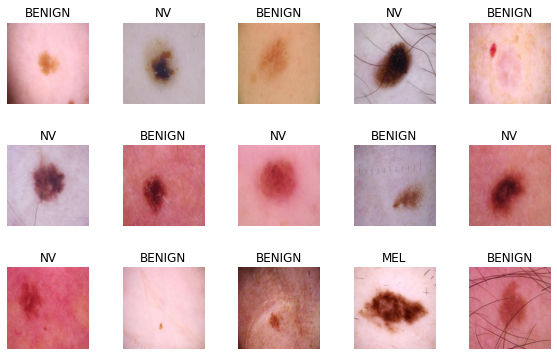

In [22]:
import matplotlib.pyplot as plt
import torch

n_rows = 3
n_cols = 5

plt.figure(figsize=(n_cols * 2.0, n_rows * 2.0))

# Get a batch to work with
for images_batch, labels_batch in train_loader:
    break  # Exit after getting the first batch

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        
        # Convert the tensor image to NumPy and change CxHxW to HxWxC format for displaying
        img = images_batch[index].numpy().transpose((1, 2, 0))
        plt.imshow(img)  # Assuming your images are normalized, you might need to scale them back for proper visualization
        
        # Assuming labels are encoded as indices, directly use the label for title
        # If your labels are one-hot encoded, this part would need to adjust
        class_label = labels_batch[index].item()  # Assuming labels are not one-hot encoded
        class_label_name = label_names[class_label]  # Assuming label_names is a list of class names
        
        plt.title(class_label_name)
        plt.axis('off')  # Hide axes for better visualization

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


## Performing Image Augumentation using Multiprocessing

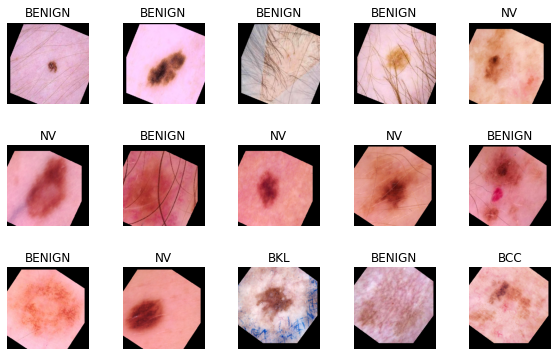

In [23]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from multiprocessing import Pool
import numpy as np

# Assuming 'train_loader' and 'label_names' are available

# Define the image augmentation pipeline
image_augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=0.15 * 360),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

def augment_and_prepare_image(args):
    img_tensor, labels_batch, index = args
    # Convert tensor to PIL Image for augmentation
    img_pil = transforms.ToPILImage()(img_tensor)
    img_augmented = image_augmentation(img_pil)
    # Convert back to tensor
    img_tensor_augmented = transforms.ToTensor()(img_augmented)
    img_np = img_tensor_augmented.numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    class_label = labels_batch[index].item()
    return (index, img_np, class_label)

# Get a batch to work with
for images_batch, labels_batch in train_loader:
    break

n_rows = 3
n_cols = 5

args = [(images_batch[index], labels_batch, index) for index in range(n_rows * n_cols)]

# Use multiprocessing Pool to process images in parallel
if __name__ == '__main__':  # Required for multiprocessing to work properly
    with Pool(processes=4) as pool:  # Adjust the number of processes based on your system
        results = pool.map(augment_and_prepare_image, args)

    # Sort results by index to maintain order
    results.sort(key=lambda x: x[0])

    ### Step 2: Sequential Plotting

    plt.figure(figsize=(n_cols * 2.0, n_rows * 2.0))

    for index, img_np, class_label in results:
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(img_np)
        plt.axis('off')
        class_label_name = label_names[class_label]
        plt.title(class_label_name)

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()


### Next we'll cache the datasets for performance, and use a prefetch buffer so the CPU can be performing image augmentation on the next batch at the same time the GPU is performing gradient descent on the current one.

In [24]:
from torch.utils.data import DataLoader

# Assuming train_dataset, val_dataset, and test_dataset are already defined

# Configure your DataLoaders with multiprocessing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, prefetch_factor=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        num_workers=4, prefetch_factor=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         num_workers=4, prefetch_factor=2, pin_memory=True)


# The ResNet Model¶
## Step 1: Train just the Classifier
We'll first take off the old head from the model (with include_top=False) and replace it with our own classifier for our specific data. First we'll freeze all the model weights and only train our classifier head.

In [25]:
import torchvision.models as models

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)




/home/padyal.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/padyal.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bias=None):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet50 model
        self.base_model = models.resnet50(pretrained=pretrained)
        
        # Retain all layers except the original fully connected layer at the end
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        
        # Custom fully connected layer (classifier). Note the correction here to use self.base_model
        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        # Initialize the bias of the last layer if bias is provided
        if bias is not None:
            self.fc.bias.data = bias

    def forward(self, x):
        x = self.features(x)  # Extract features
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)  # Flatten
        x = self.fc(x)  # Classify
        return x


In [27]:
num_classes = 8  # Adjust to your number of classes
model = CustomResNet(num_classes=num_classes, pretrained=True)


In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.fc.parameters(), lr=1e-2)  # Optimize classifier only


In [29]:
import torch

# Check if CUDA (GPU support) is available and use it if possible, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the specified device
model = model.to(device)


In [30]:
# Assuming you have a DataLoader named 'train_loader'
for inputs, labels in train_loader:
    # Move data to the same device as the model
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = criterion(outputs, labels)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    



In [31]:
loss_fn = nn.CrossEntropyLoss()

In [32]:

# Set model to evaluation mode
model.eval()

CustomResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [33]:
# No need to track gradients for this operation
with torch.no_grad():
    for image_batch, label_batch in train_loader:
        # Move data to the same device as the model
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)

        # Perform a forward pass and calculate the loss
        outputs = model(image_batch)
        loss = loss_fn(outputs, label_batch)
        
        # Break after processing the first batch
        break

print(f"Initial Loss: {loss.item():0.4f}")

Initial Loss: 0.7410


Since our dataset is imbalanced, the bias in the final classifier should not be set to 0.

Because it is, then the default loss in the final softmax layer should be -log(1/n_classes) (predicts them with equal probabilities) or -log(1/8) here (where log is natural log). Which is a loss of 0.741. This is pretty close to what we measured above.

In a multi-class classification scenario using neural networks, the final layer often consists of a fully connected (dense) layer followed by a softmax activation function. Each neuron in this dense layer corresponds to a class. Adjusting the bias terms for each class can help in dealing with class imbalance by influencing the initial predictions of the model before training starts.



# Callbacks¶
We'll use Early Stopping to stop the model if the validation loss stops improving.

We'll also reduce the learning rate when learning starts to plateau.

In [37]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [38]:
class_weight_tensor = class_weight_tensor.to(device)

In [39]:
model_device = next(model.parameters()).device
tensor_device = class_weight_tensor.device

# Print the devices to verify
print("Model device:", model_device)
print("Tensor device:", tensor_device)

# Check if they are on the same device
if model_device == tensor_device:
    print("The tensor is on the same device as the model.")
else:
    print("The tensor and model are on different devices.")

Model device: cuda:0
Tensor device: cuda:0
The tensor is on the same device as the model.


# Using Model Parallel to Train

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bias=None, device_ids=None):
        super(CustomResNet, self).__init__()
        self.device_ids = device_ids
        
        # Load a pre-trained ResNet50 model
        self.base_model = models.resnet50(pretrained=pretrained)
        
        # Retain all layers except the original fully connected layer at the end
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        
        # Custom fully connected layer (classifier). Note the correction here to use self.base_model
        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        # Initialize the bias of the last layer if bias is provided
        if bias is not None:
            self.fc.bias.data = bias
        
        if self.device_ids is not None:
            self.features = nn.DataParallel(self.features, device_ids=cuda0)
            self.fc = nn.DataParallel(self.fc, device_ids=cuda1)

    def forward(self, x):
        # If device IDs are specified, move input to the first device
        if self.device_ids is not None:
            x = x.to(self.device_ids[0])
        
        # Pass input through feature extractor layers
        x = self.features(x)
        
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Classify
        x = self.fc(x)
        
        return x


In [43]:
model = CustomResNet(num_classes=num_classes, pretrained=True)

# Here we are only training on 10 epochs to save time

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import copy



# Create an instance of your model
EPOCHS= 10

# Define the device on which to run the model (e.g., 'cuda' if using GPU)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Assuming your model is defined as `model`
# Clone the model to ensure independent weights
model_clone = copy.deepcopy(model)

# Move the original model to the specified device
model.to(device)

# Define the loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weight_tensor)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example learning rate

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

# Early stopping
early_stopping = EarlyStopping(patience=2, verbose=True, path='checkpoint.pt')

# Initialize the model parallelism
# Split the model into multiple parts and move each part to a different device
model_clone.to(device)
model_clone = nn.DataParallel(model_clone)

start_time = time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_clone(inputs)  # Forward pass through the model
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Reduce LR on plateau
    scheduler.step(val_loss)
    
    # Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
        
training_time = time() - start_time
print(f"Training completed with {torch.cuda.device_count()} GPUs. Time taken: {training_time:.2f} seconds")

# Load the best model weights
model.load_state_dict(torch.load('checkpoint.pt'))


/home/padyal.s/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 2.1250, Validation Loss: 2.0661
Validation loss decreased (inf --> 2.066137).  Saving model ...
Epoch 2, Training Loss: 2.1225, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 3, Training Loss: 2.1232, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 4, Training Loss: 2.1213, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 5, Training Loss: 2.1228, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 6, Training Loss: 2.1252, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 7, Training Loss: 2.1237, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch 8, Training Loss: 2.1228, Validation Loss: 2.0661
Validation loss decreased (2.066137 --> 2.066137).  Saving model ...
Epoch

<All keys matched successfully>

# We tried using Distributed Data parallel also but were facing issues while establshing connection with the server port. So we droped it

# Using Dataparallel

In [45]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bias=None):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet50 model
        self.base_model = models.resnet50(pretrained=pretrained)
        
        # Retain all layers except the original fully connected layer at the end
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        
        # Custom fully connected layer (classifier). Note the correction here to use self.base_model
        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        # Initialize the bias of the last layer if bias is provided
        if bias is not None:
            self.fc.bias.data = bias

    def forward(self, x):
        x = self.features(x)  # Extract features
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)  # Flatten
        x = self.fc(x)  # Classify
        return x


In [46]:
# Assuming 'model' is your PyTorch model

print(f"Let's use {torch.cuda.device_count()} GPUs!")
model = nn.DataParallel(model)



Let's use 3 GPUs!


In [47]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import copy

model_clone = copy.deepcopy(model)
# Assuming your model is defined as `model`
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    
# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=0.001)  # Example learning rate

# Define the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weight_tensor)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

# Early stopping
early_stopping = EarlyStopping(patience=2, verbose=True, path='checkpoint.pt')

start_time = time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Reduce LR on plateau
    scheduler.step(val_loss)
    
    # Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
        
training_time = time() - start_time
print(f"Training completed with {torch.cuda.device_count()} GPUs. Time taken: {training_time:.2f} seconds")


# Load the best model weights
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 1, Training Loss: 1.6754, Validation Loss: 1.3846
Validation loss decreased (inf --> 1.384596).  Saving model ...
Epoch 2, Training Loss: 1.4521, Validation Loss: 1.3720
Validation loss decreased (1.384596 --> 1.371975).  Saving model ...
Epoch 3, Training Loss: 1.3743, Validation Loss: 1.2825
Validation loss decreased (1.371975 --> 1.282459).  Saving model ...
Epoch 4, Training Loss: 1.2764, Validation Loss: 1.1335
Validation loss decreased (1.282459 --> 1.133453).  Saving model ...
Epoch 5, Training Loss: 1.1863, Validation Loss: 1.2641
EarlyStopping counter: 1 out of 2
Epoch 6, Training Loss: 1.1559, Validation Loss: 3.1511
EarlyStopping counter: 2 out of 2
Early stopping triggered
Training completed with 3 GPUs. Time taken: 484.45 seconds


<All keys matched successfully>

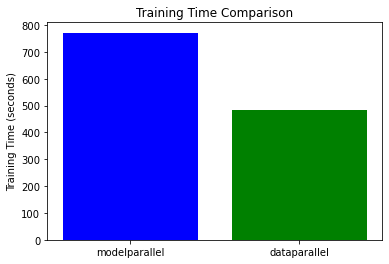

In [102]:
import matplotlib.pyplot as plt

# Example training times in seconds
training_model_parallel = 771.23  
training_data_parallel = 484.45  

# Names of the configurations
configurations = ['modelparallel', 'dataparallel']

# Corresponding training times
times = [training_model_parallel, training_data_parallel]

# Creating the bar plot
plt.bar(configurations, times, color=['blue', 'green'])

plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()


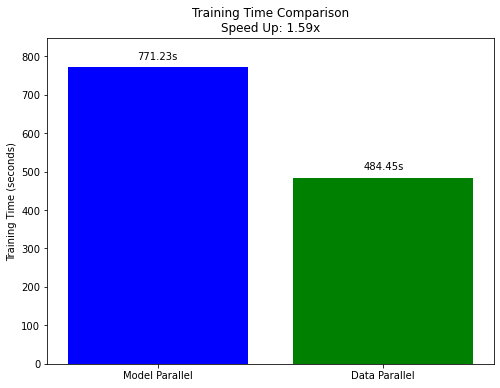

1.5919702755702343

In [103]:
import matplotlib.pyplot as plt

# Example training times in seconds
training_model_parallel = 771.23  
training_data_parallel = 484.45  

# Names of the configurations
configurations = ['Model Parallel', 'Data Parallel']

# Corresponding training times
times = [training_model_parallel, training_data_parallel]

# Calculate speed up
speed_up = training_model_parallel / training_data_parallel

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(configurations, times, color=['blue', 'green'])

plt.ylabel('Training Time (seconds)')
plt.title(f'Training Time Comparison\nSpeed Up: {speed_up:.2f}x')
plt.ylim(0, max(times) * 1.1)  # Set y-axis limit to make sure text fits
for i, time in enumerate(times):
    plt.text(i, time + 20, f'{time:.2f}s', ha='center')

plt.show()

speed_up


## !! Thank You !!